In [44]:
# ======基于Tensorflow的basic word2vec===========
"""Basic word2vec example."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
#下面是为了解决matplotlib显示中文的问题
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [45]:
# 读取文件，将文件中的句子转成词汇列表
filename = './QuanSongCi.txt'                      # 文件名
def read_data(filename):
    with open(filename, encoding="utf-8") as f:
        data = f.read()
        data = list(data)
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 1903073


In [46]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 5000
words = vocabulary
n_words = vocabulary_size - 1
count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(n_words - 1)) 
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary) 
for word in words[:20]:
    index = dictionary.get(word,0)    

In [47]:
data = list()
unk_count = 0
for word in words: 
    index = dictionary.get(word, 0) 
    if index == 0:   
        unk_count += 1
    data.append(index)
count[0][1] = unk_count
reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [48]:
batch_size=128 #8
num_skips=2;skip_window=1
data_index = 0
global data_index 
assert batch_size % num_skips == 0 
assert num_skips <= 2 * skip_window
 
batch = np.ndarray(shape=(batch_size), dtype=np.int32)
labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

span = 2 * skip_window + 1
buffer = collections.deque(maxlen=span)
 
if data_index + span > len(data):
    data_index = 0  
buffer.extend(data[data_index : data_index+span]) 
data_index += span                                 

for i in range(batch_size // num_skips):  
    context_words = [w for w in range(span) if w != skip_window] 
    
    words_to_use = random.sample(context_words,num_skips) 
    
    for j,context_word in enumerate(words_to_use):   
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j,0] = buffer[context_word] 
    
    if data_index == len(data):
        buffer.extend(data[0:span]) 
        data_index = span 
    else:
        buffer.append(data[data_index])
        data_index += 1

data_index = (data_index + len(data) - span) % len(data)

In [49]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)


In [54]:
graph = tf.Graph()                               # 创建graph
with graph.as_default():                        # 设置为默认的graph
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32) 

    with tf.device('/cpu:0'): 
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)   

        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))  
        nce_biases = tf.Variable(tf.zeros([vocabulary_size])) 

    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset) 
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    init = tf.global_variables_initializer()

In [55]:
# Step 5: Begin training.
# 开始训练
num_steps = 200001

with tf.Session(graph=graph) as session:
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps): 
        batch_inputs, batch_labels = batch,labels 
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict) 
        average_loss += loss_val 

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        if step % 10000 == 0:  
            sim = similarity.eval()
            for i in range(valid_size): 
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8  
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word             
                 
                for k in range(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
                
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  215.3495330810547
Nearest to 来: 镗, 挑, 嚬, 爬, 趱, 恒, 糟, 孟,
Nearest to 事: 宕, 铁, 矛, 懋, 计, 投, 袂, 黻,
Nearest to 寒: 弗, 阜, 纲, 咳, 庠, 滟, 嘲, 瓢,
Nearest to 水: 黔, 刺, 包, 枢, 洄, 羯, , 克,
Nearest to 与: 仙, 塔, 灼, 劚, 捋, 量, 啮, 颙,
Nearest to 歌: 潦, 兴, 茵, 级, 兹, 卓, 菊, 仝,
Nearest to 深: 燥, 队, 煌, 逅, 脍, 住, 瞻, 未,
Nearest to 尽: 驮, 殿, 鬒, 隐, 陌, 箨, 宏, 麈,
Nearest to ）: 著, 几, 栩, 讯, 秾, :, 题, 薤,
Nearest to 江: 敧, 戎, 推, 晒, 铎, 态, 淰, 沁,
Nearest to 长: 谐, 捺, 荃, 侠, 婪, 钩, 飨, 蜩,
Nearest to 空: 醿, 萏, 燧, 斫, 跻, 穟, 盏, 叇,
Nearest to 梦: 靶, 环, 籍, 租, 探, 槌, 饶, 价,
Nearest to 金: 於, 糯, 镝, 溱, 堞, 柝, 拭, 搂,
Nearest to 有: 轶, 顿, 轧, 萝, 胚, 局, 妾, 苓,
Nearest to 明: 绝, 溯, 旻, 卧, 珂, 俏, 罚, 踵,
Average loss at step  2000 :  14.162044836729764
Average loss at step  4000 :  1.0905571313798428
Average loss at step  6000 :  1.0259532076120377
Average loss at step  8000 :  1.0221946882307529
Average loss at step  10000 :  1.0127956046462059
Nearest to 来: 别, 
, 隋, 寰, 。, 之, 分, 放,
Nearest to 事: 宕, 铁, 矛, 分, （, 懋, 计, 投,
Nearest to 寒:

Average loss at step  92000 :  1.0040486652255058
Average loss at step  94000 :  0.9970768890380859
Average loss at step  96000 :  0.999924722135067
Average loss at step  98000 :  0.9995954159200191
Average loss at step  100000 :  0.9954248082637787
Nearest to 来: 之, 经, 季, 是, 隋, 分, 掩, 别,
Nearest to 事: 宕, 铁, 矛, 懋, 计, 投, 袂, 黻,
Nearest to 寒: 弗, 阜, 纲, 咳, 庠, 滟, 嘲, 瓢,
Nearest to 水: 潺, 季, 是, 障, 四, 隋, （, 粤,
Nearest to 与: 仙, 塔, 灼, 劚, 捋, 量, 啮, 颙,
Nearest to 歌: 潦, 兴, 茵, 级, 兹, 卓, 菊, 仝,
Nearest to 深: 燥, 队, 煌, 逅, 脍, 住, 瞻, 未,
Nearest to 尽: 驮, 殿, 鬒, 隐, 陌, 箨, 宏, 麈,
Nearest to ）: 几, 
, 。, 是, 障, 异, 别, 长,
Nearest to 江: 敧, 戎, 推, 晒, 铎, 态, 淰, 沁,
Nearest to 长: 是, 经, 
, 异, 。, ）, 映, 分,
Nearest to 空: 醿, 萏, 燧, 斫, 跻, 穟, 盏, 叇,
Nearest to 梦: 靶, 环, 籍, 租, 探, 槌, 饶, 价,
Nearest to 金: 於, 糯, 镝, 溱, 堞, 柝, 拭, 搂,
Nearest to 有: 轶, 顿, 轧, 萝, 胚, 局, 妾, 苓,
Nearest to 明: 是, 经, 四, 一, 当, 不, 映, （,
Average loss at step  102000 :  0.9949460099935532
Average loss at step  104000 :  1.001329254180193
Average loss at step  106000 :  0.9931212

Average loss at step  192000 :  0.9905284448862076
Average loss at step  194000 :  0.9980870316028595
Average loss at step  196000 :  0.990584470897913
Average loss at step  198000 :  0.9961720753312111
Average loss at step  200000 :  0.989284222304821
Nearest to 来: 经, 之, 季, 一, 是, 翠, ，, 隋,
Nearest to 事: 宕, 铁, 矛, 懋, 计, 投, 袂, 黻,
Nearest to 寒: 弗, 阜, 纲, 咳, 庠, 滟, 嘲, 瓢,
Nearest to 水: 潺, 障, 季, 是, 粤, 隋, 。, 四,
Nearest to 与: 仙, 塔, 灼, 劚, 捋, 量, 啮, 颙,
Nearest to 歌: 潦, 兴, 茵, 级, 兹, 卓, 菊, 仝,
Nearest to 深: 燥, 队, 煌, 逅, 脍, 住, 瞻, 未,
Nearest to 尽: 驮, 殿, 鬒, 隐, 陌, 箨, 宏, 麈,
Nearest to ）: 几, 
, 。, 长, 异, 是, 障, 柳,
Nearest to 江: 敧, 戎, 推, 晒, 铎, 态, 淰, 沁,
Nearest to 长: 异, ）, 
, 经, 。, 是, 映, 当,
Nearest to 空: 醿, 萏, 燧, 斫, 跻, 穟, 盏, 叇,
Nearest to 梦: 靶, 环, 籍, 租, 探, 槌, 饶, 价,
Nearest to 金: 於, 糯, 镝, 溱, 堞, 柝, 拭, 搂,
Nearest to 有: 轶, 顿, 轧, 萝, 胚, 局, 妾, 苓,
Nearest to 明: 经, 是, 四, 当, 几, 一, 不, 隋,


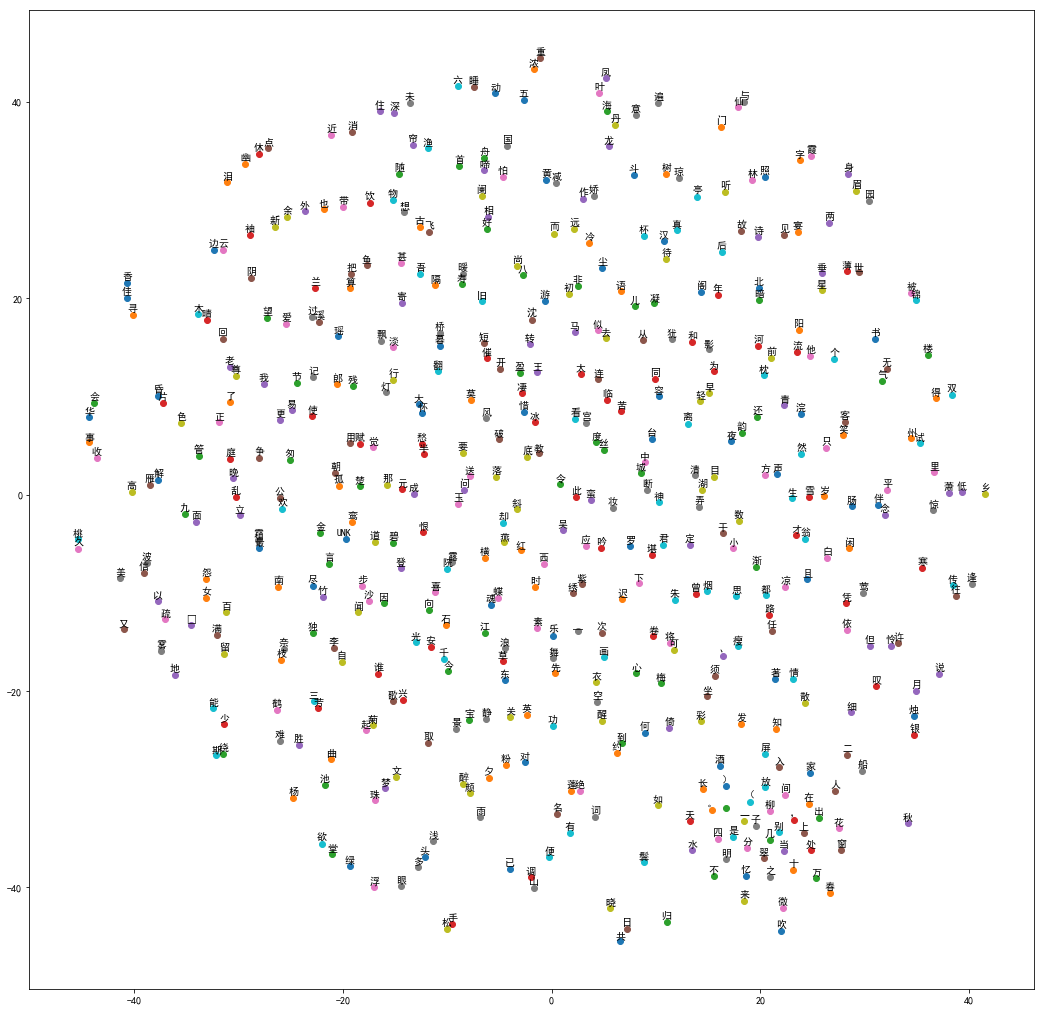

In [57]:
# Step 6: Visualize the embeddings.


# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reversed_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

np.save('embedding.npy', final_embeddings)

In [59]:
import collections
import json
with open("./dictionary.json","w",encoding='utf-8') as f:
    json.dump(dictionary,f)

with open("./reverse_dictionary.json","w",encoding='utf-8') as f:
    json.dump(reversed_dictionary,f)